<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/TEST_Camembert_LM%26TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 2.9MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 


In [2]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 3.0MB/s 
     |████████████████████████████████| 901kB 17.3MB/s 
     |████████████████████████████████| 3.3MB 21.0MB/s 


In [3]:
!pip install -Uq nbdev

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


In [4]:
from inspect import signature

In [5]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# CamentBERT

In [6]:
!pip install sentencepiece

from transformers import CamembertTokenizer, CamembertForCausalLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True)
model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True, add_cross_attention=True)

#transformers.RobertaForCausalLM.from_pretrained(pretrained_model_name_or_path='roberta-base', add_cross_attention=True, is_decoder=True, bos_token_id=<bos-id>, eos_token_id=<eos-id>)?

     |████████████████████████████████| 1.2MB 2.9MB/s 


Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.5.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.8.crossattention.self.query.weight', 'roberta.encoder.layer.8.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.6.crossattention.self.query.bias', 'roberta.encoder.layer.3.crossattention.self.value.bias', 'roberta.encoder.layer.9.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.8.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.self.query.bias', 'roberta.encoder.layer.1.crossattention.self.value.weight', 'roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.4.crossattention.self.query.weight', 'roberta.encoder.layer.7.crossattention.self.query.weight', 'roberta.encod

NOTE: Language Modeling
- **Causal language modeling**: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
- **Masked language modeling**: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

In [7]:
model.eval()

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Testing the tokenizer

Its always good to know what special tokens your tokenizer needs, lets have a look:

In [8]:
# special tokens
tokenizer.special_tokens_map

{'additional_special_tokens': "['<s>NOTUSED', '</s>NOTUSED']",
 'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

In [9]:
tokenizer.vocab_size

32005

In [10]:
ids = tokenizer.encode('Ce texte est affligeant, et')
ids

[5, 148, 930, 30, 5639, 1187, 17059, 7, 14, 6]

In [11]:
# decoding
tokenizer.decode(ids)

'<s> Ce texte est affligeant, et</s>'

# Getting the data

In [12]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [13]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [14]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [15]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [16]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


NOTE: polarity: `0` negative review; `1` positive review

In [17]:
val_df = pd.read_json(path/'data/val.jsonl', lines=True, nrows=1000)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [18]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = False, index = False)

In [19]:
val_df.to_csv(path/'data/val.csv', encoding = 'utf-8', header = False, index = False)

In [20]:
# training dataset
df_train = pd.read_csv(path/'data/train.csv', encoding = 'utf-8', header=None)
df_train.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [21]:
# validation dataset
df_valid = pd.read_csv(path/'data/val.csv', encoding = 'utf-8', header=None)
df_valid.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0
1,http://www.allocine.fr/film/fichefilm-272/critiques/spectateurs,"The Wall a été réalisé par Alan Parker (Fame, Midnight Express, Evita) et Roger Waters (bassiste de Pink Floyd). Le film ne contient quasiment aucun dialogue, il s'agit en fait du double album conceptuel The Wall en images. Pink est une rock star déchue qui utilise tous les paradis artificiels possibles pour fuir le réel, mais cela ne fait que l'enfoncer encore plus dans son état sombre. Ce film est tout autant fascinant que dérangeant : on regarde cet homme sombrer dans la paranoïa, sans pouvoir rien faire, comme les spectateurs pervers d'une mise à mort, fascinés par cette chose incontrô...",1


In [22]:
print(train_df['polarity'].unique(), val_df['polarity'].unique())

[0 1] [0 1]


In [23]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

In [24]:
print(len(train_df), len(val_df), len(all_texts))

10000 1000 11000


### Testing the tokenizer on movie review

In [25]:
some_review = train_df.review[0]; some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [26]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [27]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [28]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [29]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [30]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [31]:
# tls.train[0],tls.valid[0]

In [32]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([332]), torch.Size([93]))

In [33]:
show_at(tls.train, 0)

Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou laiss

In [34]:
show_at(tls.valid, 0)

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.


## Dataloader

In [35]:
#bs,sl = 4,256 # not working
bs,sl = 4, 256
dls_lm = tls.dataloaders(bs=bs, seq_len=sl)

In [36]:
dls_lm.tfms

Pipeline: TransformersTokenizer

In [37]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"Encore un métrage mineur dans la filmographie de Gregg Araki qui parle d’une relation à trois provoquée par l’héroïne principale étant trop indécise quant à ses préférences amoureuses. Si Veronica campée par Kathleen Robertson est mignonne comme tout, l’ensemble est d’une mièvrerie pathétique. Les garçons sont idiots à souhait, la meilleure amie artiste avec un accent anglais énervante au possible, quant au scénario (quel scénario?) il est sans enjeu véritable et cousu de fils blancs. Bref, à éviter! L'histoire est banale et l'épouvante n'est pas au rendez-vous. On s'ennuie, on baille et on s'endort devant des prestations médiocres et des effets spéciaux qui font plus pitié que peur ""Pulp, a film about life, death and supermarkets"" est consacré au dernier concert du groupe ""Pulp"" dans leur ville de Sheffield 25 ans après leur débuts et suite à une reformation mise en oeuvre par leur lead singer, Jarvis Crocker. Le film","un métrage mineur dans la filmographie de Gregg Araki qui parle d’une relation à trois provoquée par l’héroïne principale étant trop indécise quant à ses préférences amoureuses. Si Veronica campée par Kathleen Robertson est mignonne comme tout, l’ensemble est d’une mièvrerie pathétique. Les garçons sont idiots à souhait, la meilleure amie artiste avec un accent anglais énervante au possible, quant au scénario (quel scénario?) il est sans enjeu véritable et cousu de fils blancs. Bref, à éviter! L'histoire est banale et l'épouvante n'est pas au rendez-vous. On s'ennuie, on baille et on s'endort devant des prestations médiocres et des effets spéciaux qui font plus pitié que peur ""Pulp, a film about life, death and supermarkets"" est consacré au dernier concert du groupe ""Pulp"" dans leur ville de Sheffield 25 ans après leur débuts et suite à une reformation mise en oeuvre par leur lead singer, Jarvis Crocker. Le film est"
1,"'élucider cette question) au cours duquel de multiples rencontres lui permettent de débattre de sujets philosophiques (assez pointus, il faut aimer le sujet pour ne pas se trouver larguer en cours de route. Et je ne dis pas ça pour faire l'intelligent, hein, mais plutôt pour souligner le fait que ce film ne plaira pas nécessairement à ceux qui ne s'intéressent pas à la philosophie pure!). Mais le film, succession de dialogues et de monologues en images, peut captiver par son originalité visuelle. Le film est donc unique dans son genre. Il a d'ailleurs été primé ou nominé dans plusieurs festivals (Venise, Berlin). Le thème est bien traité, à mon avis, et les questions posées ne sont pas anodines. Très bon film du brésilien Hector Babenco. Sur un thème assez classique (deux prisonniers dans la même cellule), le scénario est enrichi par récit imaginaire bien venu, de plus les rapports","élucider cette question) au cours duquel de multiples rencontres lui permettent de débattre de sujets philosophiques (assez pointus, il faut aimer le sujet pour ne pas se trouver larguer en cours de route. Et je ne dis pas ça pour faire l'intelligent, hein, mais plutôt pour souligner le fait que ce film ne plaira pas nécessairement à ceux qui ne s'intéressent pas à la philosophie pure!). Mais le film, succession de dialogues et de monologues en images, peut captiver par son originalité visuelle. Le film est donc unique dans son genre. Il a d'ailleurs été primé ou nominé dans plusieurs festivals (Venise, Berlin). Le thème est bien traité, à mon avis, et les questions posées ne sont pas anodines. Très bon film du brésilien Hector Babenco. Sur un thème assez classique (deux prisonniers dans la même cellule), le scénario est enrichi par récit imaginaire bien venu, de plus les rapports"


## Tokenizing the Allocine Dataset

In [38]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [39]:
len(tokenized)

11000

In [40]:
tokenizer.vocab_size

32005

In [41]:
# adding tokens to the vocab
tokenizer.add_tokens('tokenized')
# resizing the model
model.resize_token_embeddings(len(tokenizer))

Embedding(32006, 768)

In [42]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

## Learner

In [43]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [44]:
# del learn

In [45]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [46]:
learn.model

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32006, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [47]:
learn.validate()

(#2) [14.1454439163208,1390875.375]

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

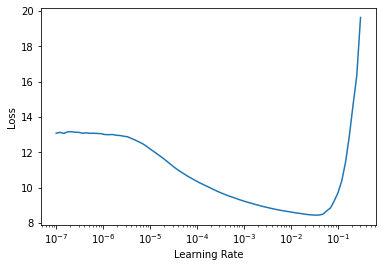

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.147872,3.981411,53.592575,01:56


## Saving the trained model

In [50]:
# saving the newly trained model
learn.save('1epoch')

Path('models/1epoch.pth')

## Saving the model's vocabulary

In [51]:
# saving the vocabulary
vocab= tokenizer.save_vocabulary('/content/allocine/data/')

NOTE: the file name is `sentencepiece.bpe.model`

In [52]:
# other way to save the vocabulary by making a list
vocab_lm = list(tokenizer.get_vocab()) #dictionary

In [53]:
vocab_lm[:10]

['<s>NOTUSED',
 '<pad>',
 '</s>NOTUSED',
 '<unk>',
 '<s>',
 '</s>',
 ',',
 '▁de',
 '.',
 's']

In [54]:
type(vocab_lm)

list

In [55]:
len(vocab_lm)

32005

In [56]:
# vocab size assertion
assert(len(vocab_lm) == tokenizer.vocab_size) # it returns True!

## Inference

In [57]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [58]:
#prompt = "ce film est un navet, il met en"
prompt = "c'est une histoire abracadabrantesque"

In [59]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 13])

In [60]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

In [61]:
tokenizer.decode(preds[0].cpu().numpy())

"<s> c'est une histoire abracadabrantesque</s> on se demande ce qu'il y a a faire dans ce film. Il y a beaucoup d'action, de rebondissements"

NOTE: The model 'RobertaForCausalLM' is not supported for text-generation. Supported models are ['XLNetLMHeadModel', 'TransfoXLLMHeadModel', 'ReformerModelWithLMHead', 'GPT2LMHeadModel', 'GPTNeoForCausalLM', 'OpenAIGPTLMHeadModel', 'CTRLLMHeadModel', 'TFXLNetLMHeadModel', 'TFTransfoXLLMHeadModel', 'TFGPT2LMHeadModel', 'TFOpenAIGPTLMHeadModel', 'TFCTRLLMHeadModel']

# Text Classification

In [62]:
path

Path('/content/allocine')

In [63]:
df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=30000)
df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [64]:
# splitting a df by rows
df_train = df.iloc[10001:-1]; len(df_train)

19998

In [65]:
df_train.to_csv(path/'data/train1.csv', encoding = 'utf-8', header = True, index = False)

In [66]:
df_train.head(1)

,film-url,review,polarity
10001,http://www.allocine.fr/film/fichefilm-50911/critiques/spectateurs,"Quel navet!!!! Un mix entre une réalisation classique et caméra à l'épaule, des acteurs insupportables (voir la rousse dans la voiture donne une irrésistible envie de gifler), un tueur sans charisme..... Légérement gore qui tâche, aucune sensation de stress ne vient nous titiller l'esprit. Slasher basique sans aucun génie, ce film est à oublier voir même à ne pas regarder. Malgré son 1h10, pas possible de le terminer.",0


## Text Tokenization


In [67]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [68]:
print('[CLS] token :', tokenizer.cls_token)
print('[SEP] token :', tokenizer.sep_token)
print('[PAD] token :', tokenizer.pad_token)

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [69]:
tokenizer.pad

<bound method PreTrainedTokenizerBase.pad of PreTrainedTokenizer(name_or_path='camembert-base', vocab_size=32005, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED']})>

In [70]:
# text_block = TransformBlock(type_tfms=[TransformersTokenizer(tokenizer)],
#                             dls_kwargs={'before_batch':Pad_Chunk(pad_idx=tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})

In [71]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return TensorText(self.tokenizer(x, truncation=True)['input_ids'])
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu()))

class HFTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, tokenizer):
        type_tfms = TransformersTokenizer(tokenizer)
        psd_first = tokenizer.padding_side == 'left'
        #pad_first = tokenizer.padding_side=='left')
        return super().__init__(type_tfms=type_tfms,
                                dl_type= SortedDL,
                                dls_kwargs={'before_batch':Pad_Chunk(pad_idx = tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})



NOTE: HFTextBlock is designed to work with vanilla Learner
TransLearner on the other hand expects xb to contain a dictionary (as returned by TokBatchTransform in the example notebook).  So there are 2 passes to take here either use Learner or modify data pipeline. Feel free to ping me here if you choose the second one and need some assistance


## Text Dataloader

In [72]:
# # Using TextBlock.from_df without vocab
# dls_clas = DataBlock(
#         blocks=(TextBlock.from_df('review', is_lm=False, vocab=None), CategoryBlock),
#         get_y=ColReader('polarity'), 
#         get_x=ColReader('text'), # res_col_name should be "text"?
#         splitter=RandomSplitter()
# ).dataloaders(df_train, bs=16, seq_len=512)

In [73]:
dblock = DataBlock(
        blocks=(HFTextBlock(tokenizer), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('review'),
        splitter=RandomSplitter()
)

dls_clas = dblock.dataloaders(train_df, bs=16)

In [74]:
dls_clas.show_batch(max_n=3)

,text,category
0,"<s> Bon, c'est vrai que ça sentait pas très bon à première vue, mais l'appel des nouveaux implants capillaires de Nicolas Cage (ici en chanteur de Nickelback) a été le plus fort. Mais bon, à part ça : ouille que ça pique aux yeux! Les dix premières minutes suffisent à poser les bases : un fantastique de pacotille brodé par une intrigue brouillonne durant laquelle on voit pleins de gars se balancer des boules de feux ; mais aussi des très risibles « Horvath, tu m'as trahi! » lâchés sur un simple regard par un Merlin (oui oui, il est là...) à la voix de golgoth, le tout sur fond d'une Monica Belucci qui ne fera qu'une brève apparition juste le temps de se faire emprisonner dans une « gigogne » (oui, c'est un mot que j'ai découvert moi aussi, mais il faudra s'y faire : le film regorgeant de",0
1,"<s> En lisant les critiques presses d'Allociné je n'ai pu réprimer un sourire narquois doublé d'une profonde exaspération. Tant de bêtise, c'est presque inhumain. On parle d'expérimental? De Palme d'Or? D'Antonioni? Arrêtons les fantasmes. Mieux encore : « «Millennium Mambo» va encore plus loin dans une voie où l'abstraction géométrique n'empêche pas mais nourrit la précision réaliste, où l'artifice parvient à atteindre la vérité », signé Le Monde. Ou comment décrire du vide en disant du vide... «Millennium Mambo» ou de l'uniformisation des cultures. Car au fond c'est la seule vraie qualité du long métrage, montrer qu'aujourd'hui à Taïwan la vie d'une jeune fille d'une vingtaine d'années est incroyablement similaire à celle des jeunes européen(ne)s, et sans doute des jeunes américain(e)s du même âge. Hou Hsiao Hsien voulait rendre compte du mode de vie de la jeunesse de son pays, il l'a fait avec brio, simplicité et efficacité. Le style",0
2,"<s> Je ne serais sans doutes jamais aller voir ce film si les circonstances ne m'y avaient contraint. Séance familiale de rattrapage (le film est sorti il y a 4 mois) oblige. Je découvre ""La Famille Bélier"" au cinéma à l'heure où celui-ci est déjà sorti en DVD et Blu-Ray! Ce film ne m'attirait pas spécialement. Sur le papier, l'histoire de Paula, seule ""entendante"" d'une famille de sourds, qui, pour couronner le tout, se voit dotée d'une voix magnifique par un Créateur plus indescriptible que jamais sentait l'air frais, mais le tout traité sous forme de comédie par Eric Lartigau, avec pour vedette une ancienne de The Voice, cela pouvait paraître... comment dire... incongru? Nauséabond? Mais en même temps il y avait François Damiens et Karin Viard et puis la bande-annonce était assez sobre et promettait un truc sympa. Fifty-fifty donc. En gros : au ciné je verrais quand temps",1


In [75]:
print(len(dls_clas.train), len(dls_clas.valid))

500 125


In [76]:
dls_clas.c, dls_clas.vocab

(2, [0, 1])

## Text Learner

In [77]:
# from transformers import CamembertConfig, CamembertForSequenceClassification

In [78]:
del learn

In [77]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

In [80]:
@delegates(Learner.__init__)
class TransLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        splitter = kwargs.get('splitter', None)
        if splitter is None: kwargs['splitter'] = default_splitter
        super().__init__(dls, model, **kwargs)
        self.add_cb(TransCallback(model))

In [81]:
class TransCallback(Callback):
    "Handles HuggingFace model inputs and outputs"
    
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    # def before_batch(self):
    #     if 'labels' in self.xb[0].keys():
    #         self.labels = (self.xb[0]['labels'], )
    #     # make a tuple containing an element for each argument model excepts
    #     # if argument is not in xb it is set to default value
    #     self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])

    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])
    
    def after_pred(self):
        if 'loss' in self.pred:
            self.learn.loss_grad = self.pred.loss
            self.learn.loss = self.pred.loss.clone()
        self.learn.pred = self.pred.logits
    
    def after_loss(self):
        if len(self.labels):
            self.learn.yb = self.labels
            self.labels = tuple()

In [82]:
# model = CamembertForSequenceClassification.from_pretrained("camembert-base")

In [83]:
# learn_clas = text_classifier_learner(dls_clas, model, drop_mult=0.5, 
#                                 metrics=accuracy).to_fp16()

In [84]:
# model = CamembertForSequenceClassification.from_pretrained("camembert-base")
# learn = TransLearner(dls_clas, model, 
#                      metrics=accuracy).to_fp16()

In [78]:
# from transformers import AutoModelForSequenceClassification

In [79]:
model_name = "camembert-base"

In [87]:
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# learn = TransLearner(dls_clas, model, metrics=accuracy).to_fp16()

In [80]:
model = AutoModelForSequenceClassification.from_pretrained(model_name)
learn = Learner(dls_clas, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=accuracy).to_fp16() 

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [81]:
learn.model

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.0004786300996784121)

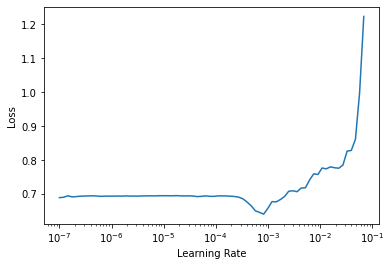

In [83]:
learn.lr_find()

In [84]:
bs, sl

(4, 256)

In [85]:
learn.fit_one_cycle(1, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.188188,0.156946,0.953500,01:00


In [86]:
# xb,yb= learn.dls.one_batch()
# xb.shape, yb.shape

In [87]:
# learn = learn.load('1epoch')

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=0.00019054606673307717)

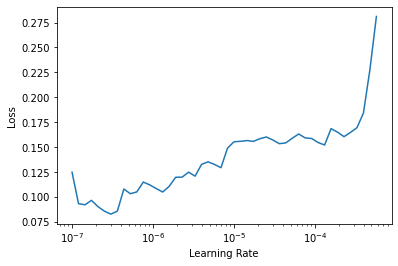

In [88]:
learn.lr_find()

In [89]:
# gradual unfreezing - unfreezing the last couple of layer groups
learn.freeze_to(-2)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-5/(2.6**4),1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.157637,0.122777,0.958000,01:00


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.2908675418875646e-06)

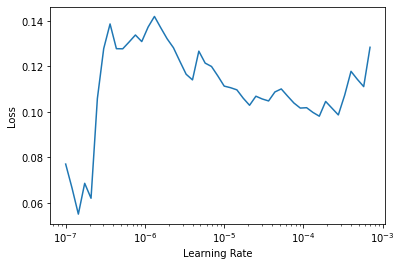

In [90]:
learn.lr_find()

In [91]:
# gradual unfreezing - unfreezing the last three of layer groups
learn.freeze_to(-3)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.131916,0.122808,0.954000,01:00


In [92]:
# unfreezing
learn.unfreeze()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=5.754399353463668e-06)

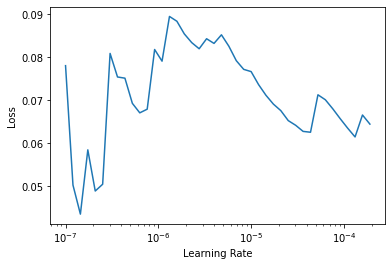

In [93]:
learn.lr_find()

In [94]:
# using discriminative learning rates
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.156285,0.143886,0.951000,01:00
1,0.048180,0.124999,0.958500,01:00


## Evaluate

In [95]:
# amr predicting sentiment analysis
learn.predict("Ce film est vraiment marrant")
#learn.predict("Ce film est un navet")

('1', tensor(1), tensor([0.0114, 0.9886]))

In [96]:
# amr predicting sentiment analysis
#learn.predict("Ce film est vraiment marrant")
learn.predict("Ce film est un navet")

('0', tensor(0), tensor([0.9971, 0.0029]))

In [97]:
learn.show_results()

,text,category,category_
0,"<s> Mon dieu, bijou, je crois qu'on a jamais été aussi proche du vide total, putain dire qu'un film de Bay est vide, qu'un Paranomal Activity c'est de la merde pourrait paraître être de la mauvaise foi lorsqu'on a vu Devil Inside. Je pense que l'on peut sans aucun problème en faire le nouvel maître étalon de la médiocrité. Ce qu'il y a de génial dans ce film c'est qu'il n'y a rien, mais rien du tout à sauver. Déjà il faut le voir en VF, la synchronisation labiale faite par des amateurs, ça vaut le coup d'oeil. Il n'y a pas vraiment de scénario, et c'est encore moins cohérent, genre le prêtre possédé qui arrive à rentrer dans une église et à qui la croix de ne fait rien... C'est juste génial de voir à quel point c'est rien du tout. Je pense qu'on peut se rapprocher avec ce",0,0
1,"<s> Bravo! Bravo vraiment au cinéma pour ce résultat! Non mais franchement, de qui se moque-t-on? Mon père est femme de ménage long-métrage réalisé par Saphia Azzeddine raconte l'histoire de Polo, un adolescent mal dans sa peau ( comme par hasard ) dont le père est femme de ménage avec qui il va prendre confiance en lui etc... On a l'impression d'avoir vu ce film cent fois. Du déjà-vu, du déjà-vu, du déjà-vu. Le film de la réalisatrice franco-marocaine est navrant de bêtises, d'ignominies, de sornettes. Tout sonne faux dans Mon père est femme de ménage, tout à commencer par la manière dont sont brossés les personnages ( et venant d'une réalisatrice licenciée en sociologie, c'est limite etc ) avec encore une fois l'adolescent mal dans sa peau et le père cool mais aussi une soeur inintéressante, superficielle, inculte et bien-sûr elle est blonde ( tiens, donc ), les amis",0,0
2,"<s> Mon dieu! Quelle métaphore filée! Je suis abasourdi! Mais réellement, ici on a une métaphore filée de l'acceptation que sa mère puisse à nouveau avoir une sexualité avec quelqu'un d'autre que son papounet chéri! Freud est aux anges et moi aussi! Sauf qu'en fait c'est nul... Ce n'est pas un Disney Channel Original Movie très intéressant, faut dire qu'il est franchement vieux, il date de l'an 2000, d'un autre millénaire! Les gens qui ont fait ce film n'ont pas connu le 11 septembre! Vous vous rendez compte? Toute cette candeur était encore possible! époque bénie des dieux! Outre la blague, on retrouve déjà tous les poncifs du genre, la meilleure amie noire, l'ennemie qui devient l'amie... la belle soeur qui au début énerve et puis finalement on s'y attache... oh que c'est mignon... ça me donne la nausée. Bref vous n'aurez compris rien que du très classique ici, mais",0,0
3,"<s> Voir Playtime rue de Rennes, à l'Arlequin, ancien cinéma Le Lux Rennes, puis Le Cosmos, mais rebaptisé l'Arlequin par Jacques Tati, lorsqu'il en était le propriétaire. Donc, voir l'univers de Plattime, où tout paysage est soumis à la relativité de l'angle de vue. un monument surgit d'un reflet capté dans l'ouverture d'une porte ou du fait de l'inclinaison d'une baie vitrée. Le verre est transparent, il peut aussi refléter, on peut s'y mirer ou y apercevoir l'autre inaccessible. La rencontre n'est jamais gagnée chez Tati, on se cherche beaucoup, on arpente l'espace à la recherche d'une possible rencontre. Le temps défie l'espace. Dans Playtime, les clones de Mr Hulot prolifèrent. Au Royal Garden, qui ouvre alors que les travaux sont inachevés, ce sera ""jour de fête"", une atmosphère débridée, due au génie d'un richissime américain, qui transforme les catastrophes, en délimitant un nouvel usage de l'espace. Mr Hulot rencontre",1,1
4,"<s> Je voulais le voir par souci d’écologie, parce qu’on ne pense pas à ces petits insectes comme condition sine qua non à notre survie, puis comme cri d’alarme pour leur survie. En fait de cela on se retrouve avec un reportage sur les abeilles mais mal fait. En effet, l’histoire traite tantôt des abeilles, tantôt des problèmes qu’elles rencontrent un peu partout, tantôt d’autre chose. La trame n’aide pas à la compréhension car elle part dans tous

In [98]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

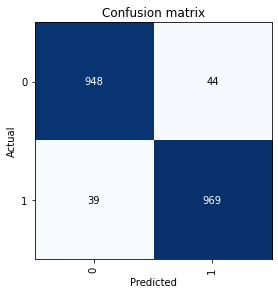

In [99]:
interp.plot_confusion_matrix()

In [100]:
interp.plot_top_losses(9, figsize=(15,11))

,input,target,predicted,probability,loss
0,<s> Ultra lourd ce film! Compliquée cette société bresilienne...</s>,1,0,0.9969897270202637,5.80574893951416
1,"<s> Pas un film pour tout le monde, c'est sûr. (Mère) Theresa filme avec sa tête et son ventre. elle voit tout, saisit tout. Ses yeux nous crèvent d'avance. Epuisés, vidés, abandonnés. On ressort comme des larves du film prêts à nous lover dans notre confort douillet, brancher la tv, rallumer son portable, dormir, travailler. Bientôt les vacances. (Mère) Théresa filme comme si elle était un mec sauf que c'est une femme. Du genre à remettre les mecs à leur place. (Mère) Theresa prend la parole pour ceux qui n'en ont pas. Elle pousse un cri. Violent!</s>",1,0,0.9964550733566284,5.642223358154297
2,"<s> Volontairement dégueulasse et assez mal réalisé, Cradle Of Fear, s'adresse avant tout aux Fans du groupe Cradle Of Filth qui apprecierons le film rien que pour Dani Filth! :)=</s>",1,0,0.9963500499725342,5.613031387329102
3,"<s> La bande annonce annonçait le niveau. Un film qui renvoie Scorsese, Nolan, Villeneuve à leur chères études..... car il est dur de faire mieux. Un jeu d'acteur proche de la perfection, une intrigue qui fait passer les frères Cohen pour les réalisateurs des Bisounours, un casting de niveau mondial, un scénario qui sûrement à été écrit, réécrit, retravaillé, peaufiné pour atteindre un niveau tout bonnement exceptionnel, un humour léché, fin et tout en nuances. Bref je le conseille donc fortement. Moi, j'attendrai le Bluray pour en acheter une vingtaine et les offrir à mes pires ennemis....</s>",0,1,0.9960237741470337,5.527421474456787
4,"<s> Deux personnages seulement pour ce film, un seul lieu, une chambre, où deux amants lors d'une nuit d'amour font part belle aux confessions. Un film donc entièrement dialogué, avec des conversations portant sur l'amour essentiellement, mais aussi sur la perversion, la vie etc... Ici, le cinéaste traduit sa vision des choses, de manière originale et précise. Un bon petit film, peu commun, avec deux bons acteurs.</s>",0,1,0.9957103729248047,5.451564311981201
5,"<s> Suivez les aventures de Kull le con errant. Comme indiqué par les autres posts, c'est le réalisateur de connard le barbant qui a fait cette pure merveille. Une bien belle carrière. A voir uniquement pour les amateurs de navets qui trouveront des dialogues somptueusement nuls et des effets spéciaux d'une mocheté à couper le souffle.</s>",0,1,0.9954527616500854,5.3932294845581055
6,"<s> Étrange, émouvant et assez plombant. C'est criant de réalisme, de dépression lycéenne, d'errements adolescents, de misère sociale et d’ébullition intellectuelle. Je n'ai pas aimé les parties chantées, mais elles ont l'avantage de nous faire sentir encore plus cruellement la fragilité des personnages. A voir!</s>",0,1,0.9951040744781494,5.319361209869385
7,"<s> histoire peu banale, quant à son traitement au cinéma. Acteurs simplement épatant. Réalisation, manque de rythme comme souvent à cette époque ( les codes ont changés ), mais d'excellentes idées au final, tel que le split screen qu'on reverra souvent après dans d'autres films.</s>",0,1,0.9950946569442749,5.317417621612549
8,"<s> ""Tendre voyou"" respire et vit sixties.C'est une petite comédie sans prétention,un des premiers films où Jean-Paul Belmondo crée ses gesticulations et sa bougeotte perpétuelle.Bébel est virevoltant,irrésistible,ayant le sens du gag,du timing,n'ayant jamais peur de trop en faire.On sent qu'il prend un plaisir fou à épater son public.Une révélation qui sera un tournant dans sa carrière,et la future vedette populaire que l'on sait.En attendant,cette réalisation de Jean Becker(pas encore porté sur les décors bucoliques)se révèle diablement entraînante,et ce malgré un scénario aux abonnés absents.En somme,ce gigolo bon enfant vogue d'une femme à une autre au gré de ses besoins matériels.Ses aventures passent par Paris,Mégève,Cannes,une croisière et Tahiti.A la fin,j'aurais tendance à dire:""tel est pris qu